Notebook for generating plots for the executive summary

In [1]:
# Import dependencies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from collections import Counter
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from IPython.display import display, HTML

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Global constants
# EPOCHS = 10
IMG_WIDTH = 30
IMG_HEIGHT = 30
NUM_CATEGORIES = 43
# TEST_SIZE = 0.4

# Load sign names as a dictionary: {class_id: sign_name}
signnames_df = pd.read_csv("../resources/signnames.csv")
SIGNNAME_MAP = dict(zip(signnames_df["ClassId"], signnames_df["SignName"]))

# For combining plots together
from PIL import Image


In [2]:
# Function to load data from directory
def load_data(data_dir):
    """
    Load image data from directory `data_dir`.

    Assume `data_dir` has one directory named after each category, numbered
    0 through NUM_CATEGORIES - 1. Inside each category directory will be some
    number of image files.

    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. `labels` should
    be a list of integer labels, representing the categories for each of the
    corresponding `images`.
    """
    # Initialize lists to hold images and labels
    images = []
    labels = []

    # Process each image and append image and label to lists
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for filename in filenames:
            # Construct full file path
            image_path = os.path.join(dirpath, filename)
            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            # Normalize pixel values to the range [0, 1] by dividing by 255.0
            # And converts from an integer type to a float type
            image = image / 255.0
            # Append image and label to lists
            images.append(image)
            # Extract label from directory name
            labels.append(int(os.path.basename(dirpath)))

    # Return the tuple of images and labels
    return (images, labels)

In [3]:
# Load and split data into training, validation, and test sets

# Get image arrays and labels for all image files
images, labels = load_data("../resources/gtsrb")

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)

# First split: train vs. temp (val+test)
x_train, x_temp, y_train, y_temp = train_test_split(
    np.array(images), np.array(labels), test_size=0.4, random_state=42
)
# Second split: val vs. test (split temp into val and test)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

In [4]:
# Load models, training history, and predictions on validation set

# Open models and history
Baseline = load_model("../models/Baseline.h5")
Baseline_history = pd.read_csv("../results/Baseline_history.csv")
Winning_Model = load_model("../models/Two_Convolutional_with_Batch_Normalization.h5")
Winning_Model_history = pd.read_csv("../results/Two_Convolutional_with_Batch_Normalization_history.csv")
Overkill_Model = load_model("../models/Two_Convolutional_and_Dense_Layers.h5")
Overkill_Model_history = pd.read_csv("../results/Two_Convolutional_and_Dense_Layers_history.csv")

# Evaluate models on validation set
Baseline.evaluate(x_val, y_val, verbose=2)
Winning_Model.evaluate(x_val, y_val, verbose=2)
Overkill_Model.evaluate(x_val, y_val, verbose=2)

# Predict on validation set
y_pred_baseline = Baseline.predict(x_val)
y_pred_winning = Winning_Model.predict(x_val)
y_pred_overkill = Overkill_Model.predict(x_val)
Y_pred_classes_baseline = y_pred_baseline.argmax(axis=1)
Y_pred_classes_winning = y_pred_winning.argmax(axis=1)
Y_pred_classes_overkill = y_pred_overkill.argmax(axis=1)
Y_true = y_val.argmax(axis=1)

167/167 - 3s - loss: 0.1362 - accuracy: 0.9657 - 3s/epoch - 21ms/step
167/167 - 4s - loss: 0.0206 - accuracy: 0.9942 - 4s/epoch - 22ms/step
167/167 - 3s - loss: 0.2581 - accuracy: 0.9383 - 3s/epoch - 17ms/step
167/167 [==============================] - 3s 15ms/step


In [5]:
# Copy class distribution image to static/images for website

# Open the class distribution image
img = Image.open("../results/images/class_distribution.png")

# Save a copy to the static/images directory
img.save("../static/images/class_distribution.png")

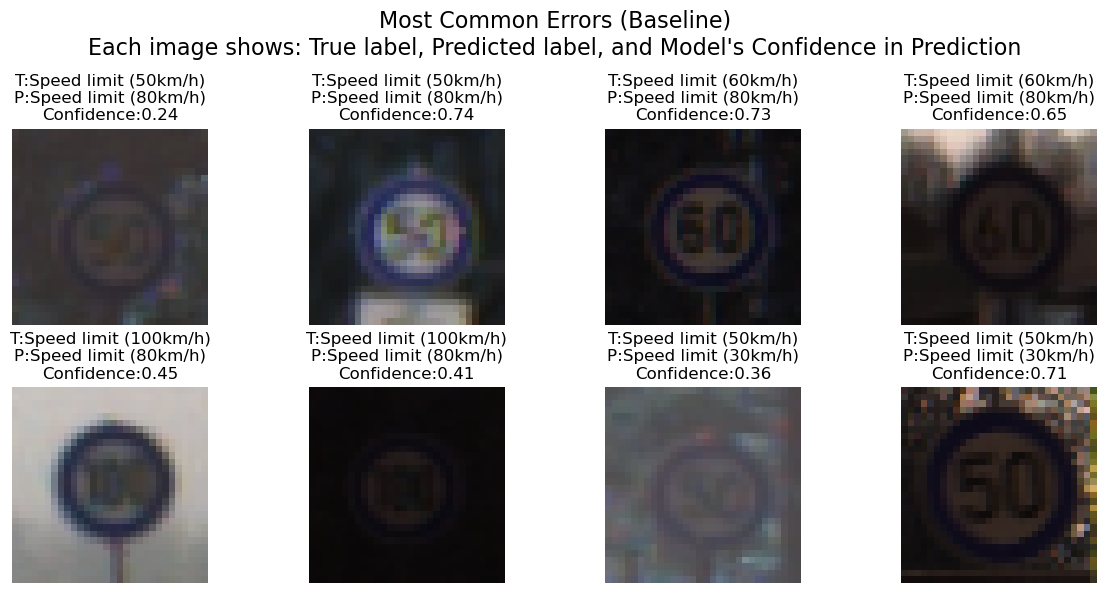

In [6]:
# Save Sampling of Error Images for Baseline Model
def show_top_misclassifications(
    x,
    y_true,
    y_pred,
    y_prob,
    signname_map=None,
    top_n=4,
    per_class=2,
    model_name="model",
):
    """
    Display and save top misclassified images.
    x: images (4D array, shape [n_samples, IMG_WIDTH, IMG_HEIGHT, 3])
    y_true: true labels (1D array, int)
    y_pred: predicted class indices (1D array, int)
    y_prob: softmax probabilities (2D array, shape [n_samples, n_classes])
    signname_map: dict mapping class_id to sign name (optional, defaults to SIGNNAME_MAP)
    top_n: number of top misclassification types to show
    per_class: number of images to show per misclassification type
    model_name: string, name to use in saved filenames
    """
    # Use default signname map if none provided
    if signname_map is None:
        signname_map = SIGNNAME_MAP

    # Find misclassifications, count occurrences, and get top N errors
    errors = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    top_errors = counter.most_common(top_n)
    images_to_show = []
    labels_to_show = []
    confidences = []

    # Collect images, labels, and confidences for top misclassifications
    for (true, pred), _ in top_errors:
        # Find indices of misclassifications
        idxs = np.where((y_true == true) & (y_pred == pred))[0]
        # Randomly shuffle and select up to `per_class` images
        if len(idxs) > per_class:
            idxs = np.random.choice(idxs, per_class, replace=False)
        # Append images, labels, and confidences
        for idx in idxs:
            images_to_show.append(x[idx])
            labels_to_show.append((true, pred))
            confidences.append(y_prob[idx, pred])

    # Plot the images
    cols = 4
    rows = int(np.ceil(len(images_to_show) / cols))
    plt.figure(figsize=(12, 6))
    # n = len(images_to_show)
    # plt.figure(figsize=(12, 12))
    plt.suptitle(
        f"Most Common Errors ({model_name.replace('_', ' ')})\n"
        "Each image shows: True label, Predicted label, and Model's Confidence in Prediction",
        fontsize=16,
    )
    for i in range(len(images_to_show)):
        plt.subplot(rows, cols, i + 1)
    # for i in range(n):
    #     plt.subplot(top_n, per_class, i + 1)
        plt.imshow(images_to_show[i])
        true_label, pred_label = labels_to_show[i]
        conf = confidences[i]
        true_name = signname_map.get(true_label, str(true_label))
        pred_name = signname_map.get(pred_label, str(pred_label))
        plt.title(f"T:{true_name}\nP:{pred_name}\nConfidence:{conf:.2f}")
        plt.axis("off")

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"./plots/misclassifications_{model_name.lower()}.png")
    plt.savefig(f"../static/images/misclassifications_{model_name.lower()}.png")
    plt.show()


# Plot misclassified images for Baseline model
show_top_misclassifications(x_val, Y_true, Y_pred_classes_baseline, y_pred_baseline, model_name="Baseline")

In [7]:
# Function to stitch images together
def stitch_images(img1_path, img2_path, out_path, direction='vertical'):
    """
    Stitch two images together and save the result.
    direction: 'vertical' (one on top of the other) or 'horizontal' (side by side)
    """
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    # Resize to match widths (for vertical) or heights (for horizontal)
    if direction == 'vertical':
        if img1.width != img2.width:
            new_width = min(img1.width, img2.width)
            img1 = img1.resize((new_width, int(img1.height * new_width / img1.width)))
            img2 = img2.resize((new_width, int(img2.height * new_width / img2.width)))
        total_height = img1.height + img2.height
        combined = Image.new('RGB', (img1.width, total_height), color=(255,255,255))
        combined.paste(img1, (0, 0))
        combined.paste(img2, (0, img1.height))
    elif direction == 'horizontal':
        if img1.height != img2.height:
            new_height = min(img1.height, img2.height)
            img1 = img1.resize((int(img1.width * new_height / img1.height), new_height))
            img2 = img2.resize((int(img2.width * new_height / img2.height), new_height))
        total_width = img1.width + img2.width
        combined = Image.new('RGB', (total_width, img1.height), color=(255,255,255))
        combined.paste(img1, (0, 0))
        combined.paste(img2, (img1.width, 0))
    else:
        raise ValueError("direction must be 'vertical' or 'horizontal'")

    combined.save(out_path)
    print(f"Combined image saved to {out_path}")

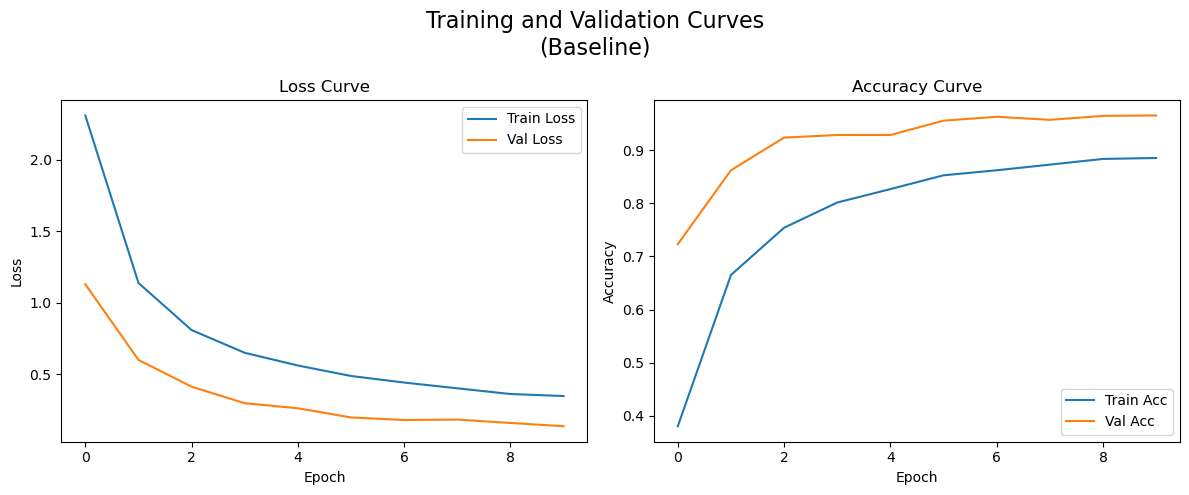

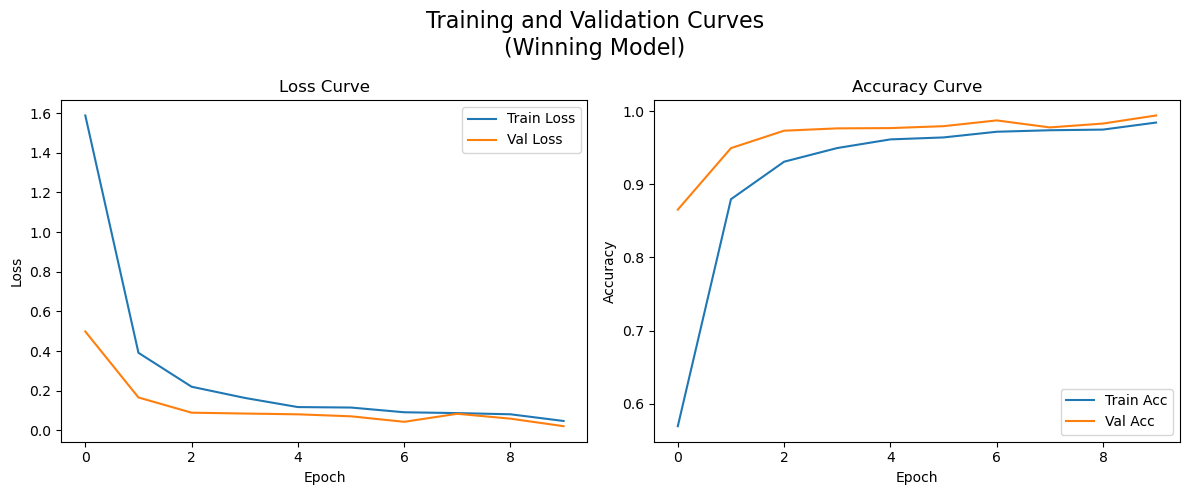

Combined image saved to ./plots/Baseline_and_Winning_Model_training_curves.png
Combined image saved to ../static/images/training_curves_comparison.png


In [8]:
# Stitch Training Curves together
def plot_and_save_training_curves(history_df, model_name="model"):
    """
    Plot and save training curves for loss and accuracy.
    history: Keras History object from model training
    model_name: string, name to use in saved filenames
    """
    plt.figure(figsize=(12, 5))
    plt.suptitle(
        f"Training and Validation Curves\n({model_name.replace('_', ' ')})", fontsize=16
    )

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history_df["loss"], label="Train Loss")
    plt.plot(history_df["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history_df["accuracy"], label="Train Acc")
    plt.plot(history_df["val_accuracy"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"./plots/{model_name}_training_curves.png")
    plt.show()


# Plot Baseline and Winning Model training curves
plot_and_save_training_curves(Baseline_history, model_name="Baseline")
plot_and_save_training_curves(Winning_Model_history, model_name="Winning_Model")

# Stitch training curves together, save here and in static/images for website
stitch_images(
    "./plots/Baseline_training_curves.png",
    "./plots/Winning_Model_training_curves.png",
    "./plots/Baseline_and_Winning_Model_training_curves.png",
)
stitch_images(
    "./plots/Baseline_training_curves.png",
    "./plots/Winning_Model_training_curves.png",
    "../static/images/training_curves_comparison.png",
)


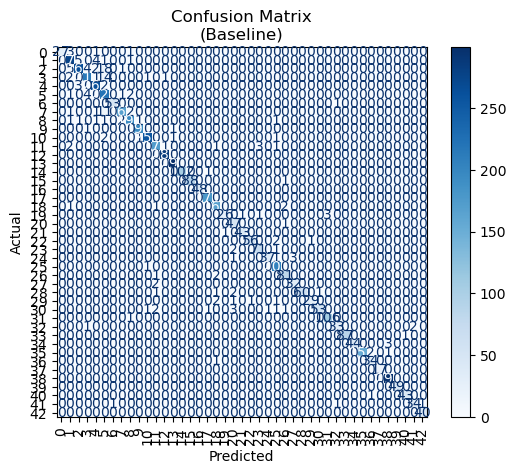

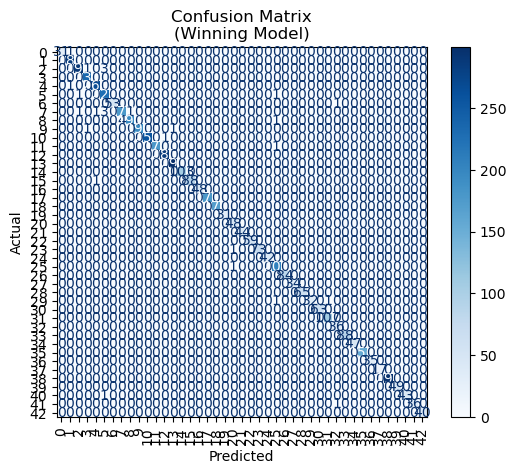

Combined image saved to ./plots/Baseline_and_Winning_Model_confusion_matrices.png
Combined image saved to ../static/images/confusion_matrix_comparison.png


In [9]:
# Stitch Confusion Matrices together
def plot_and_save_confusion_matrix(y_true, y_pred_classes, model_name="model"):
    """
    Plot and save confusion matrix.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    model_name: string, name to use in saved filenames
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title(f"Confusion Matrix\n({model_name.replace('_', ' ')})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the figure
    plt.savefig(f"./plots/{model_name}_confusion_matrix.png")
    plt.show()

# Plot Baseline and Winning Model Confusion Matrix
plot_and_save_confusion_matrix(Y_true, Y_pred_classes_baseline, model_name="Baseline")
plot_and_save_confusion_matrix(Y_true, Y_pred_classes_winning, model_name="Winning_Model")

# Stitch confusion matrices together, save here and in static/images for website
stitch_images(
    "./plots/Baseline_confusion_matrix.png",
    "./plots/Winning_Model_confusion_matrix.png",
    "./plots/Baseline_and_Winning_Model_confusion_matrices.png",
    direction="horizontal"
)
stitch_images(
    "./plots/Baseline_confusion_matrix.png",
    "./plots/Winning_Model_confusion_matrix.png",
    "../static/images/confusion_matrix_comparison.png",
    direction="horizontal"
)

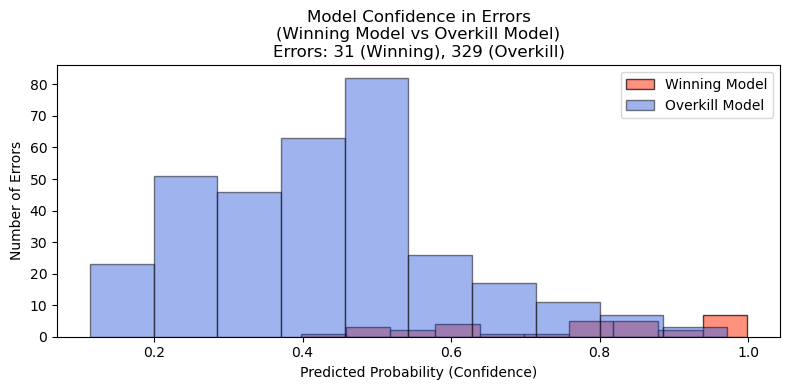

In [10]:
# Get misclassified confidences for both models
mis_winning = np.where(Y_true != Y_pred_classes_winning)[0]
conf_winning = y_pred_winning[mis_winning, Y_pred_classes_winning[mis_winning]]

mis_overkill = np.where(Y_true != Y_pred_classes_overkill)[0]
conf_overkill = y_pred_overkill[mis_overkill, Y_pred_classes_overkill[mis_overkill]]

# Plot both histograms on the same axes
plt.figure(figsize=(8, 4))
plt.hist(conf_winning, bins=10, color="tomato", edgecolor="black", alpha=0.7, label="Winning Model")
plt.hist(conf_overkill, bins=10, color="royalblue", edgecolor="black", alpha=0.5, label="Overkill Model")
plt.title(
    f"Model Confidence in Errors\n"
    f"(Winning Model vs Overkill Model)\n"
    f"Errors: {len(conf_winning)} (Winning), {len(conf_overkill)} (Overkill)"
)
plt.xlabel("Predicted Probability (Confidence)")
plt.ylabel("Number of Errors")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/confidence_histogram_comparison.png")
plt.savefig("../static/images/confidence_histogram_comparison.png")
plt.show()

167/167 [==============================] - 3s 15ms/step


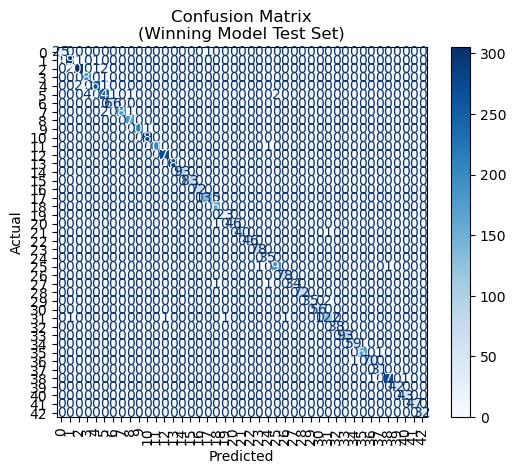

In [11]:
# Get predicted classes for the test set
y_pred_test = Winning_Model.predict(x_test)
Y_pred_classes_test = y_pred_test.argmax(axis=1)
Y_true_test = y_test.argmax(axis=1)

# Plot and save the confusion matrix for the test set
plot_and_save_confusion_matrix(Y_true_test, Y_pred_classes_test, model_name="Winning_Model_Test_Set")

# Save Winning Model Test Set to static/images for website
# Open the confusion matrix image
img = Image.open("./plots/Winning_Model_Test_Set_confusion_matrix.png")

# Save a copy to the static/images directory
img.save("../static/images/Winning_Model_Test_Set_confusion_matrix.png")

167/167 [==============================] - 3s 16ms/step


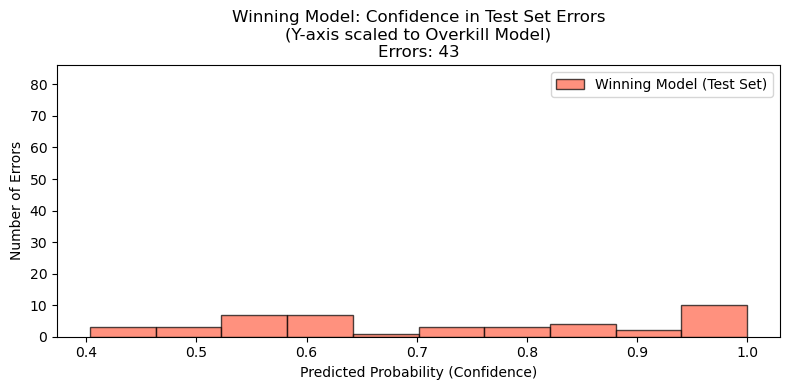

In [12]:
# Get misclassified confidences for winning model on the test set
mis_winning_test = np.where(y_test.argmax(axis=1) != Winning_Model.predict(x_test).argmax(axis=1))[0]
conf_winning_test = Winning_Model.predict(x_test)[mis_winning_test, Winning_Model.predict(x_test).argmax(axis=1)[mis_winning_test]]

# Calculate histogram bin counts for Overkill Model (for y-axis scaling)
counts_overkill, _ = np.histogram(conf_overkill, bins=10)

# Plot Winning Model histogram with y-axis scaled to Overkill Model
plt.figure(figsize=(8, 4))
plt.hist(conf_winning_test, bins=10, color="tomato", edgecolor="black", alpha=0.7, label="Winning Model (Test Set)")
plt.ylim(0, max(counts_overkill) * 1.05)  # Add a small margin
plt.title(
    f"Winning Model: Confidence in Test Set Errors\n"
    f"(Y-axis scaled to Overkill Model)\n"
    f"Errors: {len(conf_winning_test)}"
)
plt.xlabel("Predicted Probability (Confidence)")
plt.ylabel("Number of Errors")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/Winning_Model_Test_Set_histogram.png")
plt.savefig("../static/images/Winning_Model_Test_Set_histogram.png")
plt.show()